In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utility import helpers

In [2]:
from gluonts.mx import SimpleFeedForwardEstimator, Trainer

In [ ]:
# instance normalization
# train
# predict

In [6]:
datamanager = helpers.DataManager('provisioned', 4) # 4 I have saved locally
data = datamanager.load_data()

In [7]:
# Convert query_count to numpy array
query_counts = data["query_count"].to_numpy()

# Convert timestamp index to PeriodIndex (assuming hourly frequency)
start = pd.Period('2024-03-01', freq="1h")

# Display results
print("Numpy Array:\n", query_counts)
print("\nPeriodIndex:\n", start)


Numpy Array:
 [    1  8334  9573 ... 10122 10153  2388]

PeriodIndex:
 2024-03-01 00:00


In [72]:
from gluonts.dataset.common import ListDataset

freq = "1h"
t = [{"target": x, "start": start} for x in query_counts]
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset(
    [{"target": query_counts[1000:-10], "start": start}],
    freq=freq,
)

# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset(
    [{"target": query_counts[1000:-10], "start": start}], 
    freq=freq
)


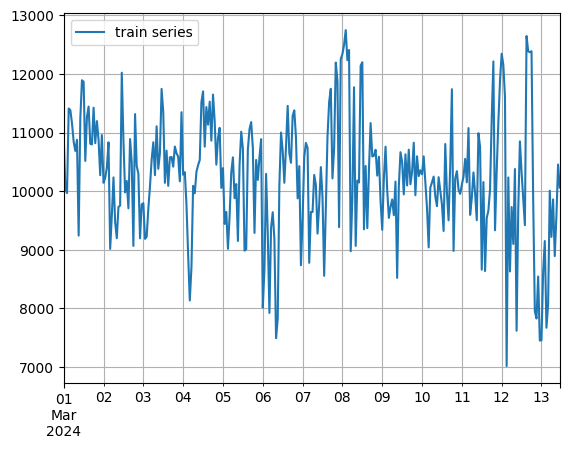

In [69]:
from gluonts.dataset.util import to_pandas

entry = next(iter(train_ds))
train_series = to_pandas(entry) # pandas.Series object

train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

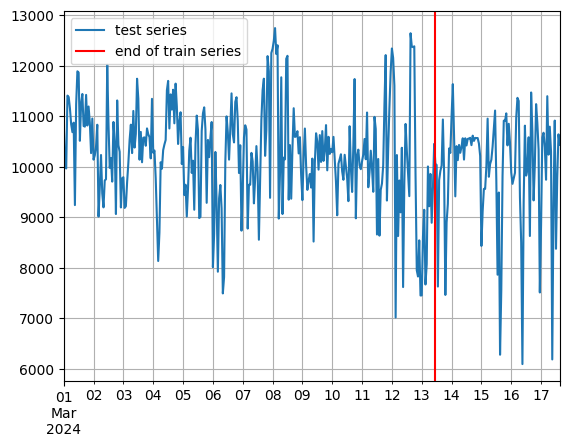

In [73]:
entry = next(iter(test_ds))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color="r")  # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()


In [71]:
print(
    f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}"
)


Length of forecasting window in test dataset: 100


In [75]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=90,
    context_length=100,
    trainer=Trainer(ctx="cpu", epochs=5, learning_rate=1e-3, num_batches_per_epoch=100),
)

In [76]:
predictor = estimator.train(train_ds)

100%|██████████| 100/100 [00:00<00:00, 133.21it/s, epoch=5/5, avg_epoch_loss=8.54]


In [104]:
from gluonts.evaluation import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [ ]:
forecasts = list(forecast_it)
tss = list(ts_it)

[                        0
 2024-03-01 00:00  10917.0
 2024-03-01 01:00  10032.0
 2024-03-01 02:00   9968.0
 2024-03-01 03:00  11411.0
 2024-03-01 04:00  11382.0
 ...                   ...
 2024-03-17 11:00  10916.0
 2024-03-17 12:00   8378.0
 2024-03-17 13:00   9777.0
 2024-03-17 14:00  10644.0
 2024-03-17 15:00  10437.0
 
 [400 rows x 1 columns]]

In [108]:
# first entry of the time series list
ts_entry = tss[0]
ts_entry

,0
2024-03-01 00:00,10917.0
2024-03-01 01:00,10032.0
2024-03-01 02:00,9968.0
2024-03-01 03:00,11411.0
2024-03-01 04:00,11382.0
...,...
2024-03-17 11:00,10916.0
2024-03-17 12:00,8378.0
2024-03-17 13:00,9777.0
2024-03-17 14:00,10644.0


In [80]:
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(
    -1,
)

array([10917., 10032.,  9968., 11411., 11382.], dtype=float32)

In [81]:
# first entry of dataset.test
dataset_test_entry = next(iter(test_ds))

In [82]:
# first 5 values
dataset_test_entry["target"][:5]

array([10917., 10032.,  9968., 11411., 11382.], dtype=float32)

In [83]:
# first entry of the forecast list
forecast_entry = forecasts[0]

print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

# print(f"Mean of the future window:\n {forecast_entry.mean}")
# print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Number of sample paths: 100
Dimension of samples: (100, 90)
Start date of the forecast window: 2024-03-13 22:00
Frequency of the time series: <Hour>


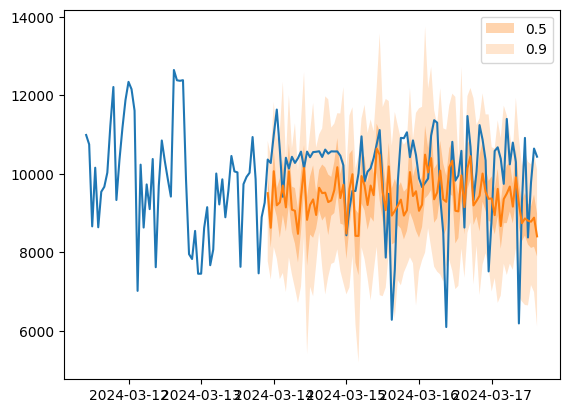

In [113]:
plt.plot(ts_entry[-150:].to_timestamp())
forecast_entry.plot(show_label=True)
plt.legend()

In [133]:
from gluonts.evaluation import Evaluator
import json

In [126]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(tss, forecasts)

Running evaluation: 1it [00:00, 36.24it/s]


In [134]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 1997072.5333333334,
    "abs_error": 106434.75,
    "abs_target_sum": 903703.0,
    "abs_target_mean": 10041.144444444444,
    "seasonal_error": 881.4855967078189,
    "MASE": 1.3416082324545637,
    "MAPE": 0.12186838785807291,
    "sMAPE": 0.12395411597357855,
    "MSIS": 9.337746322379449,
    "num_masked_target_values": 0.0,
    "QuantileLoss[0.1]": 51123.61796875,
    "Coverage[0.1]": 0.08888888888888889,
    "QuantileLoss[0.5]": 106434.7421875,
    "Coverage[0.5]": 0.17777777777777778,
    "QuantileLoss[0.9]": 52228.125195312496,
    "Coverage[0.9]": 0.5555555555555556,
    "RMSE": 1413.1781675830312,
    "NRMSE": 0.1407387549697996,
    "ND": 0.1177762494978992,
    "wQuantileLoss[0.1]": 0.056571260656155836,
    "wQuantileLoss[0.5]": 0.11777624085291295,
    "wQuantileLoss[0.9]": 0.05779346222742704,
    "mean_absolute_QuantileLoss": 69928.82845052083,
    "mean_wQuantileLoss": 0.07738032124549861,
    "MAE_Coverage": 0.2851851851851852,
    "OWA": NaN
}


In [130]:
item_metrics.head()

,item_id,forecast_start,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,num_masked_target_values,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,None,2024-03-22 06:00,1.997073e+06,106434.75,903703.0,10041.144444,881.485597,1.341608,0.121868,0.123954,0.0,0.117776,9.337746,51123.617969,0.088889,106434.742188,0.177778,52228.125195,0.555556


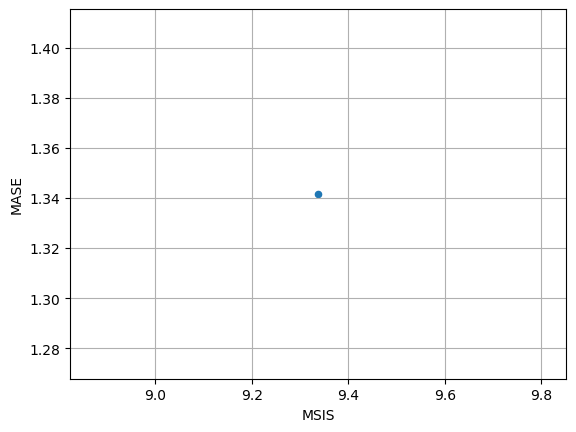

In [131]:
item_metrics.plot(x="MSIS", y="MASE", kind="scatter")
plt.grid(which="both")
plt.show()